# Tensil TCU Demo - YoloV4-tiny

### Import the TCU driver

In [2]:
import sys
sys.path.append('/home/xilinx')

# Needed to run inference on TCU
import time
import numpy as np
import pynq
from pynq import Overlay
from tcu_pynq.driver import Driver
from tcu_pynq.architecture import ultra96

# Needed for unpacking and displaying image data
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

# Needed to run model head in tflite
from functools import reduce
import tflite_runtime.interpreter as tflite
from tcu_pynq.util import div_ceil
import copy

### Configure the fabric and driver

In [3]:
overlay = Overlay('/home/xilinx/tensil_ultra96v2.bit')
tcu = Driver(ultra96, overlay.axi_dma_0)

## Demo: YoloV4-tiny inference

In this demo, we show how to run the bulk of the model (>97% of computation) on the TCU while handling the last few operations on the CPU using tflite. This configuration allows you to run more specialized operations that are not supported by the TCU.

### Load the model

In [4]:
image_size = 416
tcu.load_model('/home/xilinx/yolov4_tiny_{0}_onnx_ultra96v2.tmodel'.format(image_size))

### Instantiate tflite interpreter

In [5]:
interpreter = tflite.Interpreter(model_path='/home/xilinx/yolov4_tiny_{0}_tail.tflite'.format(image_size))
interpreter.allocate_tensors()

### Get input data

In [6]:
import cv2

original_image = cv2.imread("/home/xilinx/yolo_img/dog.jpg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image = cv2.resize(original_image, (image_size, image_size))

array_width = 16

image_data = original_image / 255.
image_data = np.pad(image_data, [(0, 0), (0, 0), (0, array_width - 3)], 'constant', constant_values=0)

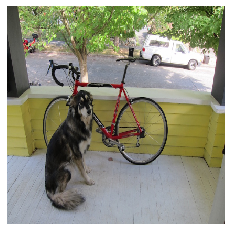

In [7]:
fig, axes1 = plt.subplots()
axes1.set_axis_off()
axes1.imshow(original_image)

### Run inference on TCU

In [8]:
inputs = {'x:0': image_data}

start = time.time()

outputs = tcu.run(inputs)

end = time.time()
print("Ran backbone inference in {:.4}s".format(end - start))
print()

print(outputs['model/conv2d_17/BiasAdd:0'])
print(outputs['model/conv2d_20/BiasAdd:0'])

Ran backbone inference in 0.8089s

[ 0.9375      0.5390625  -0.12890625 ... -5.59375    -4.76953125
  0.        ]
[ 0.34375     0.3046875   0.19921875 ... -6.83984375 -6.1171875
  0.        ]


### Run inference in tflite

In [9]:
def set_tensor(driver, interpreter, input_idx, data):
    inp = interpreter.get_input_details()[input_idx]
    data = data.astype(inp['dtype'])
    inner_dim = inp['shape'][-1]
    inner_size = div_ceil(inner_dim, driver.arch.array_size) * driver.arch.array_size
    if inner_size != inner_dim:
        data = data.reshape((-1, inner_size))[:, :inner_dim]
    data = data.reshape(inp['shape'])
    interpreter.set_tensor(inp['index'], data)

In [10]:
set_tensor(tcu, interpreter, 1, np.array(outputs['model/conv2d_17/BiasAdd:0']))
set_tensor(tcu, interpreter, 0, np.array(outputs['model/conv2d_20/BiasAdd:0']))

In [11]:
start = time.time()
interpreter.invoke()
end = time.time()
print("Ran head inference in {:.4}s".format(end - start))
print()

Ran head inference in 0.01325s



In [12]:
output_details = interpreter.get_output_details()
pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]

### Display results

In [13]:
scores, boxes = pred

In [14]:
def filter_boxes(box_xywh, scores, score_threshold=0.4, input_shape = (image_size,image_size)):
    scores_max = np.max(scores, axis=-1)

    mask = scores_max > score_threshold
    class_boxes = box_xywh[mask]
    pred_conf = scores[mask]
    class_boxes = np.reshape(class_boxes, [scores.shape[0], -1, class_boxes.shape[-1]])
    pred_conf = np.reshape(pred_conf, [scores.shape[0], -1, pred_conf.shape[-1]])

    box_xy, box_wh = np.split(class_boxes, (2,), axis=-1)

    boxes = np.concatenate([box_xy - box_wh/2, box_xy + box_wh/2], axis=-1)
    # order = np.argsort(np.max(pred_conf, axis=-1)).reshape((scores.shape[0], -1, 1))

    # return np.take_along_axis(boxes, order, axis=-2), np.take_along_axis(pred_conf, order, axis=-2)
    return boxes, pred_conf

In [15]:
b, s = filter_boxes(boxes, scores, score_threshold=0.40)

In [16]:
labels_coco = """person
bicycle
car
motorbike
aeroplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
sofa
potted plant
bed
dining table
toilet
tvmonitor
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush""".split("\n")

In [17]:
for i in np.argmax(s, axis=-1)[0]:
    print(labels_coco[i])

truck
truck
dog
dog
bicycle


In [18]:
def non_maximum_suppression(boxes, iou_threshold=0.75):
    # assumes each box is of form [x0 y0 x1 y1]
    if len(boxes) == 0:
        return boxes
    area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    ll_x = np.maximum.outer(boxes[:, 0], boxes[:, 0])
    ll_y = np.maximum.outer(boxes[:, 1], boxes[:, 1])
    ur_x = np.minimum.outer(boxes[:, 2], boxes[:, 2])
    ur_y = np.minimum.outer(boxes[:, 3], boxes[:, 3])
    intersection_x = np.maximum(0, ur_x - ll_x)
    intersection_y = np.maximum(0, ur_y - ll_y)
    intersection = intersection_x * intersection_y
    iou = intersection / area - np.identity(area.shape[-1])
    p = iou > iou_threshold
    p = p & p.T
    n =  p.shape[-1]
    
    no_needs_merge = set()
    for i in range(n):
        if not p[i].any():
            no_needs_merge.add(i)
    
    needs_merge = set()
    for i in range(n):
        for j in range(n):
            if p[i, j]:
                needs_merge.add(tuple(sorted((i, j))))

    def merge(needs_merge):
        result = list()
        for indices in needs_merge:
            result.append(indices[0])
        return result

    return list(no_needs_merge) + merge(needs_merge)

In [19]:
box_idx = non_maximum_suppression(b[0])

bicycle = 0.55
truck = 0.63
dog = 0.81


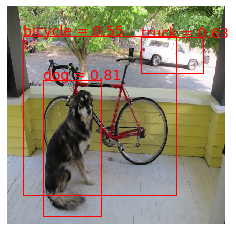

In [20]:
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(original_image)

for i in box_idx:
    box = b[0, i]
    category_idx = np.argmax(s, axis=-1)[0, i]
    category_conf = np.max(s, axis=-1)[0, i]
    text = f'{labels_coco[category_idx]} = {category_conf:.2}'
    print(text)
    x = box[0]# * input_size
    y = box[1]# * input_size
    dx = (box[2] - box[0])# * input_size
    dy = (box[3] - box[1])# * input_size
    ax.text(x, y-1, text, fontsize=14, color='red')
    ax.add_patch(plt.Rectangle((x, y), dx, dy,
             edgecolor = 'red',
             fill=False,
             lw=1))